In [2]:
:dep petgraph = "0.6.2"
:dep petgraph-evcxr = "0.2.0"
:dep micrograd_rs = { path = "." }

use std::fmt::{Display, Formatter, Result as FmtResult};
use std::rc::Rc;
use petgraph::graph::Graph;
use petgraph::graph::NodeIndex;
use petgraph_evcxr::draw_graph;
use micrograd_rs::engine::{Op, Value};
use micrograd_rs::nn::{ActFunc, Neuron};

In [3]:
// Graph node representation; useful for display purposes.
enum Node {
    ValueNode(Value),
    OpNode(Op),
}

impl Display for Node {
    fn fmt(&self, f: &mut Formatter) -> FmtResult {
        match self {
            Node::ValueNode(value) => write!(
                f,
                "data {:.4} | grad {:.4}",
                value.get_data(),
                value.get_grad()
            ),
            Node::OpNode(op) => write!(f, "{}", op),
        }
    }
}

fn show_graph(root: &Value) {
    fn build_graph(
        mut graph: &mut Graph<Node, &str>,
        value_node: Value,
        parent_node: Option<petgraph::graph::NodeIndex>,
        nodes: &mut Vec<(Value, NodeIndex)>
    ) { 
        // If value already in graph then use it's node, otherwise create a new node.
        let mut node_exists = false;
        let node = if let Some(node) = nodes.iter().find(|n| value_node == n.0) {
            node_exists = true;
            node.1
        } else {
            let node = graph.add_node(Node::ValueNode(value_node.clone()));
            nodes.push((value_node.clone(), node));
            node
        };
        
        // Connect to parent node if exists.
        if let Some(parent) = parent_node {
            // Prevent double edge, for example in case b = a + a
            if !graph.contains_edge(node, parent) {
                graph.add_edge(node, parent, "");
            }
        }
        
        // If node was already in the graph, then no need to iterate over it's children.
        if node_exists {
            return
        }

        // Create op node if exists, and recursively connect children.
        if let Some(op) = value_node.get_op() {
            let opnode = graph.add_node(Node::OpNode(op.clone()));
            graph.add_edge(opnode, node, "");
            for child in value_node.get_children() {
                build_graph(&mut graph, child.clone(), Some(opnode), nodes);
            }
        }
    }
    
    let mut graph : Graph<Node, &str> = Graph::new();
    let mut nodes: Vec<(Value, NodeIndex)> = Vec::new();
    build_graph(&mut graph, root.clone(), None, &mut nodes);
    draw_graph(&graph);
}

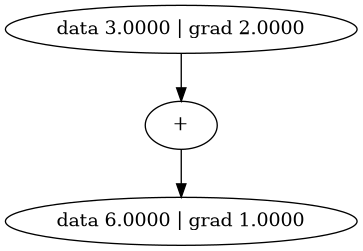

In [4]:
let a = Value::new(3.0);
let b = &a + &a;

b.backward();
show_graph(&b);

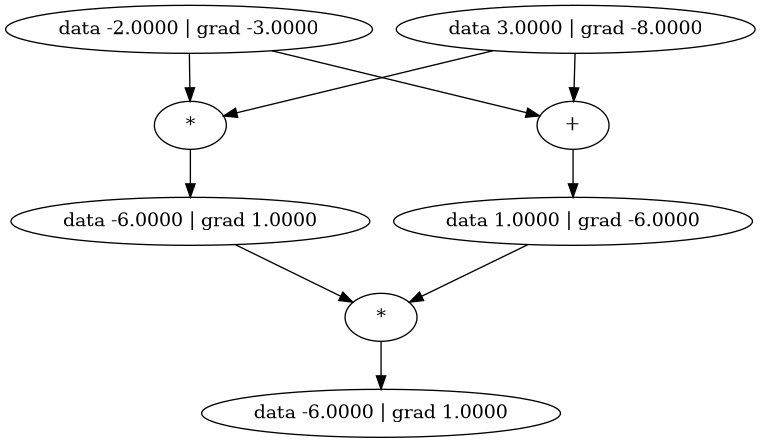

In [5]:
let a = Value::new(-2.0);
let b = Value::new(3.0);
let d = &a * &b;
let e = &a + &b;
let f = d * e;

f.backward();
show_graph(&f);

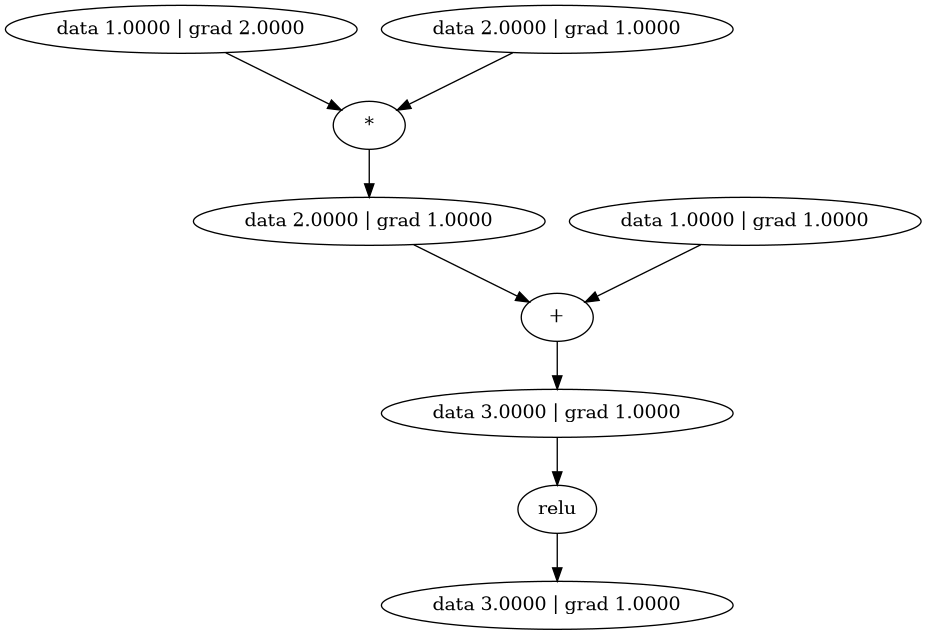

In [6]:
let x = Value::new(1.0);
let y = (x * 2.0 + 1.0).relu();

y.backward();
show_graph(&y);

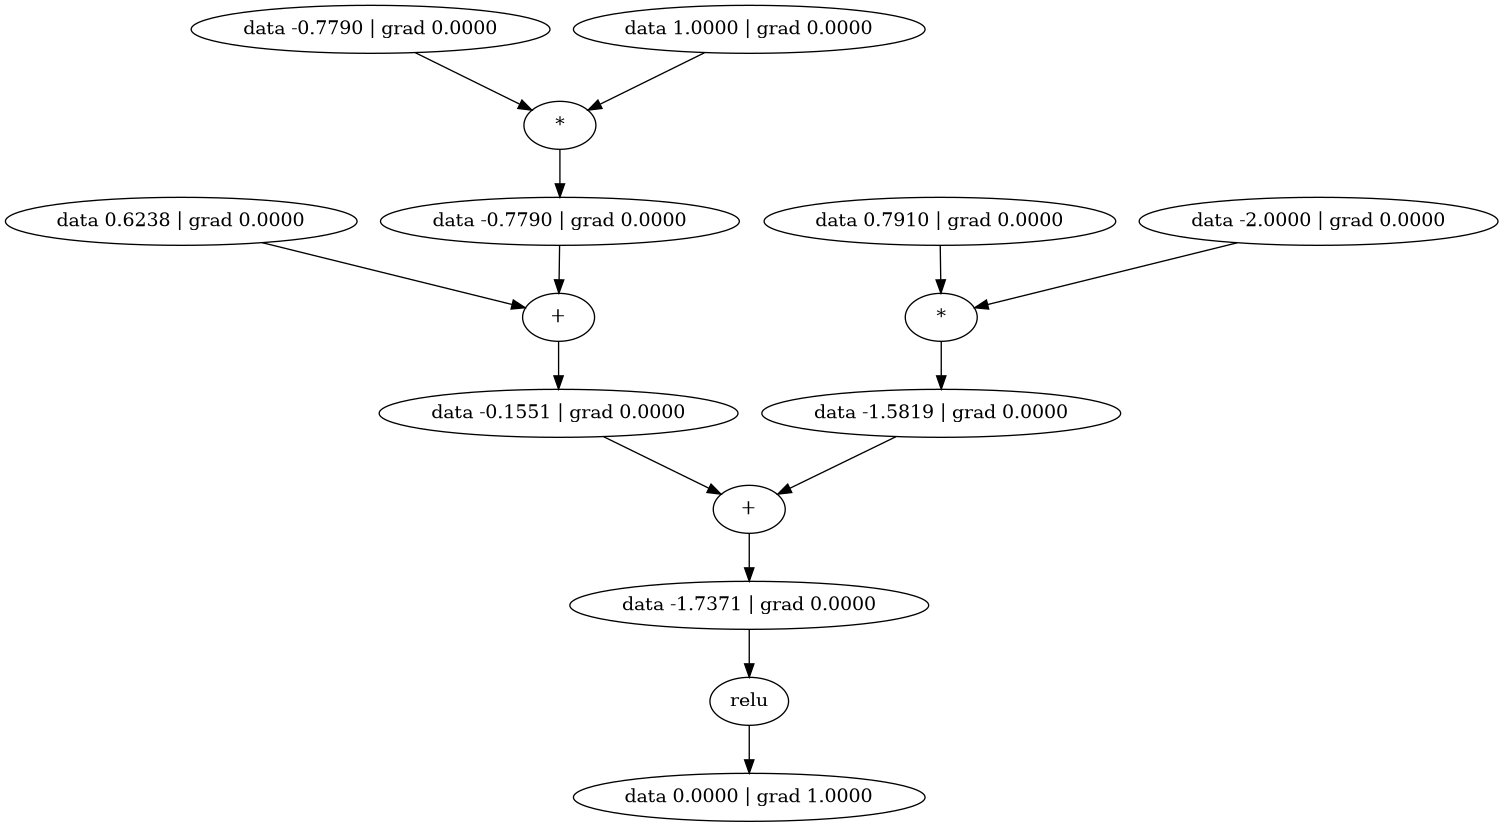

In [7]:
let n: Neuron = Neuron::new(2, true, ActFunc::ReLU);
let x = vec![Value::new(1.0), Value::new(-2.0)];
let y: Value = n.forward(x);

y.backward();
show_graph(&y);